In [3]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
import tifffile as tiff

In [4]:
# Import own helpers
from vesuvius.visualization.slices import plot_slice_grid

In [5]:
# Root folder path
ROOT = Path("~/vesuvius-scroll-detection/data/raw/vesuvius").expanduser()
img_dir = ROOT / "train_images"
mask_dir = ROOT / "train_labels"

print("ROOT:", ROOT)
print("train_images exists:", img_dir.exists())
print("train_labels exists:", mask_dir.exists())

ROOT: /Users/chamu/vesuvius-scroll-detection/data/raw/vesuvius
train_images exists: True
train_labels exists: True


In [6]:
# Load and inspect train.csv
df = pd.read_csv(ROOT / "train.csv")

display(df.head())
print("\nColumns:", list(df.columns))
print("Number of rows:", len(df))

,id,scroll_id
0,1407735,26002
1,2290837,34117
2,3320274,35360
3,8862040,34117
4,11460685,34117



Columns: ['id', 'scroll_id']
Number of rows: 806


In [7]:
# Identify ID columns
for col in ["id", "image_id", "sample_id"]:
    if col in df.columns:
        id_col = col
        break
else:
    raise ValueError(f"No ID column found. Columns: {list(df.columns)}")

In [8]:
ids = df[id_col].astype(str).tolist()

print("ID column:", id_col)
print("First 10 IDs:", ids[:10])

ID column: id
First 10 IDs: ['1407735', '2290837', '3320274', '8862040', '11460685', '11630450', '15307632', '17283971', '19797301', '26894125']


In [9]:
# Filter to valid training IDs (ie IDs that are meant for training)
valid_ids = []
missing_ids = []

for sid in ids:
    ip = img_dir / f"{sid}.tif"
    mp = mask_dir / f"{sid}.tif"
    if ip.exists() and mp.exists():
        valid_ids.append(sid)
    else:
        missing_ids.append((sid, ip.exists(), mp.exists()))

In [10]:
print("Total IDs in train.csv:", len(ids))
print("Valid train ids (image + mask):",len(valid_ids))
print("Missing IDs:", len(missing_ids))
print("Example of missing IDs (sid, image_exists, mask_exists):")
for i in range(10):
    print(missing_ids[i], end='\n')

Total IDs in train.csv: 806
Valid train ids (image + mask): 786
Missing IDs: 20
Example of missing IDs (sid, image_exists, mask_exists):
('1407735', False, False)
('808135176', False, False)
('862434992', False, False)
('885379642', False, False)
('1641318781', False, False)
('1924200298', False, False)
('1951193117', False, False)
('2075542469', False, False)
('2268221981', False, False)
('2376256768', False, False)


In [11]:
# Load valid example
sid = valid_ids[0]
img = tiff.imread(img_dir / f"{sid}.tif")
mask = tiff.imread(mask_dir / f"{sid}.tif")

In [12]:
print("sid:", sid)
print("img:", img.shape, img.dtype, "range:", (img.min(), img.max()))
print("mask:", mask.shape, mask.dtype, "range:", (mask.min(), mask.max()))
print("mask > 0 fraction:", float((mask > 0).mean()))


sid: 2290837
img: (320, 320, 320) uint8 range: (np.uint8(0), np.uint8(255))
mask: (320, 320, 320) uint8 range: (np.uint8(0), np.uint8(2))
mask > 0 fraction: 0.6267783508300782


In [13]:
# Prepare image for plotting
axis = 0
z = img.shape[axis] // 2 # middle slice

# Extract 2D slices
img2d = np.take(img, z, axis=axis)
mask2d = np.take(mask, z, axis=axis) if mask.ndim == 3 else mask

# Normalise image for visualisation
img2d = img2d.astype(np.float32) 
img2d = (img2d - img2d.min()) / (img2d.max() - img2d.min() + 1e-8)

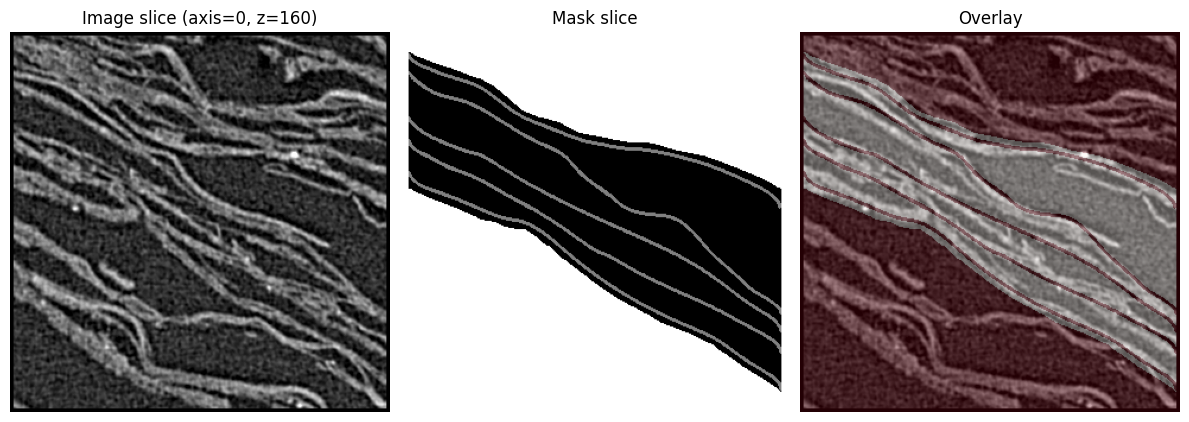

In [14]:
# Plot: image | mask | overlay
fig, ax = plt.subplots(1, 3, figsize=(12, 5))

ax[0].imshow(img2d, cmap="gray")
ax[0].set_title(f"Image slice (axis={axis}, z={z})")
ax[0].axis("off")

ax[1].imshow(mask2d, cmap="gray")
ax[1].set_title("Mask slice")
ax[1].axis("off")

ax[2].imshow(img2d, cmap="gray")
ax[2].imshow(mask2d > 0, alpha=0.35, cmap="Reds")
ax[2].set_title("Overlay")
ax[2].axis("off")

plt.tight_layout()
plt.show()

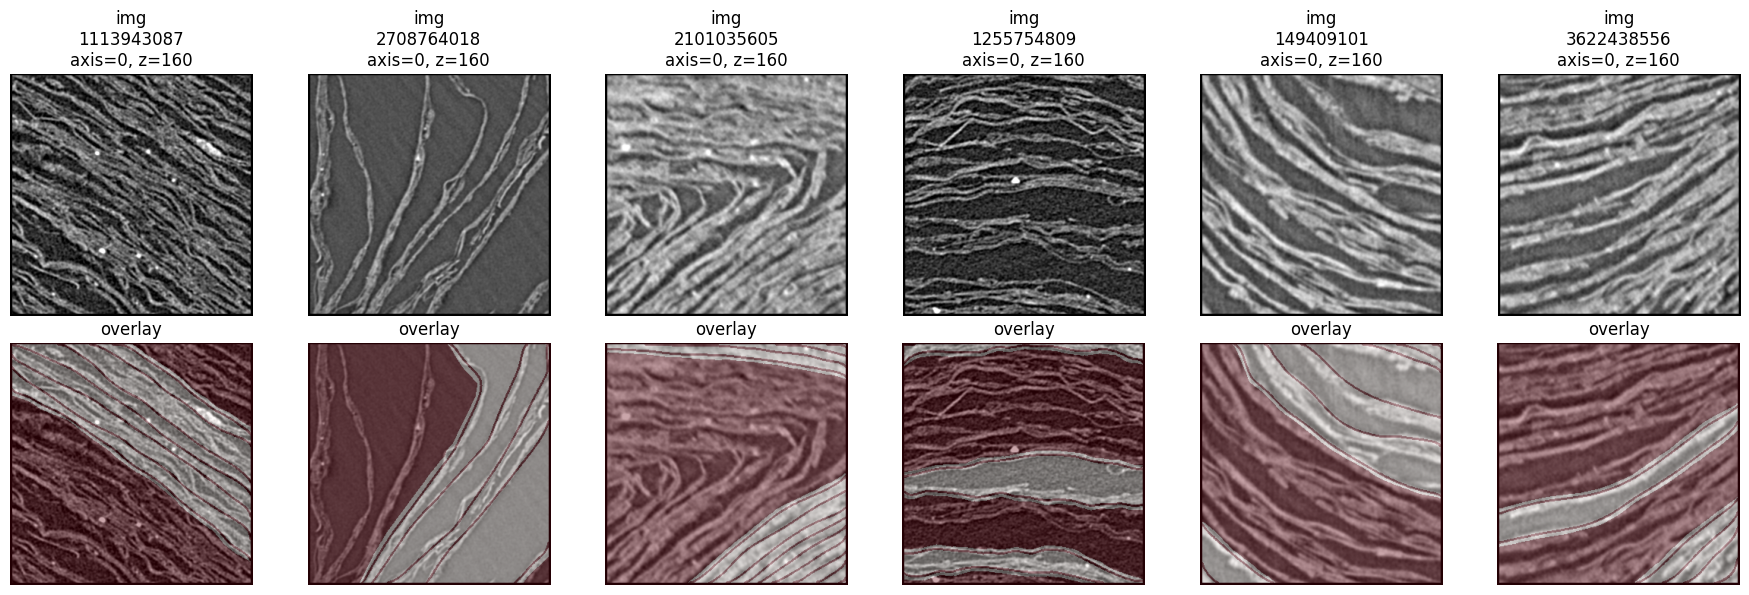

In [15]:
rng = np.random.default_rng(0)
chosen = rng.choice(valid_ids, size=6, replace=False)

plot_slice_grid(
    chosen,
    img_dir=img_dir,
    mask_dir=mask_dir,
    axis=0,
)